<a href="https://colab.research.google.com/github/angelsb008/Default_credit_card_exercise/blob/dev/Test_Default_Credit_Card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip3 install -U ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split



from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

# Define catalogues

In [3]:
sex_map = {1: 'Male', 2: 'Female'}
payment_map = {0: 'Default payment: No', 1: 'Default payment: Yes'}
education_map = {1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'}
marital_map = {1: 'married', 2: 'single', 3: 'others'}

# Methods

In [4]:
def graph_histogram_EDA(df_input, field, kde_bool = True, bin_number = 30):
  plt.figure(figsize=(8,5))
  sns.histplot(df_input[field], kde = kde_bool, bins=bin_number)
  plt.ticklabel_format(style='plain', axis='x')
  plt.title(f"Distribution of {field}")
  plt.grid()
  plt.show()

In [5]:
def pie_chart_two_fields(df_input, field_1, field_2, map_1, map_2):
    counts = df_input.groupby([field_1, field_2]).size().reset_index(name='count')
    counts['label'] = counts.apply(lambda row: f"{map_1[row[field_1]]} - {map_2[row[field_2]]}", axis=1)
    sizes = counts['count']
    labels = counts['label']
    cmap = plt.get_cmap('Pastel1')
    colors = cmap.colors[:len(sizes)]
    def func_num(pct):
        absolute = int(round(pct/100.*sum(sizes)))
        return str(absolute)
    fig, ax = plt.subplots(figsize=(7,7))
    wedges, texts, autotexts  = ax.pie(sizes, labels=labels, colors=colors, autopct=func_num,
                                      wedgeprops=dict(width=1, edgecolor='w')
    )
    plt.title(f"Probability of {field_1} per {field_2}")
    plt.show()

# Modify from https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

# Import 'Default of credit card clients' dataset

Yeh, I. (2009). Default of Credit Card Clients [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C55S3H.

In [6]:
# Code copied from https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

default_of_credit_card_clients = fetch_ucirepo(id=350)
X = default_of_credit_card_clients.data.original # change .features to .original
y = default_of_credit_card_clients.data.targets

# Dataset cleaning / preprocessing data

## First impressions

In [7]:
# Original df
X

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [8]:
# For to understand each field
print(default_of_credit_card_clients.metadata['additional_info']['variable_info'])

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
X2: Gender (1 = male; 2 = female).
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
X4: Marital status (1 = married; 2 = single; 3 = others).
X5: Age (year).
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and

## Rename fields

In [9]:
## Get actual field names
fields_list = X.columns.to_list()
## Get their respective description for each field
description_fields_list = default_of_credit_card_clients.variables["description"].tolist()
## Particular renames
description_fields_list[0] = "ID"
description_fields_list[6] = "PAY_1"
description_fields_list[-1] = "DEF_PAY_NEXT_MONTH"
## Rename
X.columns = description_fields_list
X

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Verify if exists different values that not exists into their respective catalogue per each column. If it's the case, standarding.

### For SEX field

In [10]:
## For SEX
X["SEX"].unique()

array([2, 1])

### FOR EDUCATION field

In [11]:
X["EDUCATION"].unique()

array([2, 1, 3, 5, 4, 6, 0])

In [12]:
X.loc[~X['EDUCATION'].isin([1,2,3,4]), 'EDUCATION'] = 4
X["EDUCATION"].unique()

array([2, 1, 3, 4])

### For MARRIAGE field

In [13]:
X["MARRIAGE"].unique()

array([1, 2, 3, 0])

In [14]:
X.loc[~X['MARRIAGE'].isin([1,2,3]), 'MARRIAGE'] = 3
X["MARRIAGE"].unique()

array([1, 2, 3])

### For PAY_X fields

"X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. **The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.**"

**It doesn't makes much sense that exists some repayment status with values: '0', or, '-2'**

**0 = Pending payment for the current month?**

**-2 = Pay duly twice (error system)? / Advance pay? / Credit Balance?**

In [21]:
for i in range(1, 7):
  print(f"Values in 'PAY_{i}' column: ", X[f"PAY_{i}"].unique())

Values in 'PAY_1' column:  [ 2 -1  0 -2  1  3  4  8  7  5  6]
Values in 'PAY_2' column:  [ 2  0 -1 -2  3  5  7  4  1  6  8]
Values in 'PAY_3' column:  [-1  0  2 -2  3  4  6  7  1  5  8]
Values in 'PAY_4' column:  [-1  0 -2  2  3  4  5  7  6  1  8]
Values in 'PAY_5' column:  [-2  0 -1  2  3  5  4  7  8  6]
Values in 'PAY_6' column:  [-2  2  0 -1  3  6  4  7  8  5]


In [31]:
X[X["PAY_1"]==0].iloc[5].T

,8
ID,9
LIMIT_BAL,140000
SEX,2
EDUCATION,3
MARRIAGE,1
AGE,28
PAY_1,0
PAY_2,0
PAY_3,2
PAY_4,0


### Verify doesn't exists duplicate and null values

In [32]:
# Delete possible rows duplicates in the dataset
X = X.drop_duplicates()
X

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NEXT_MONTH
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [33]:
# Check if exists any null value
X.isnull().values.any()

np.False_

In [34]:
# Delete fields without important information
X.drop(["ID"], axis=1, inplace=True)
X

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF_PAY_NEXT_MONTH
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


# EDA (Exploratory Data Analysis)

## For generate the measures of central tendency


In [35]:
# For generate the measures of central tendency
X.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.842267,0.744494,1.0,1.00,2.0,2.00,4.0
MARRIAGE,30000.0,1.557267,0.521405,1.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


## Generate graphs with EDA information

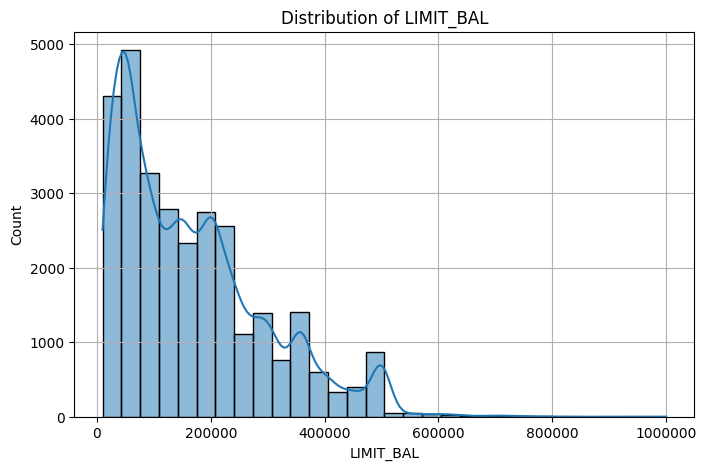

In [23]:
graph_histogram_EDA(X, "LIMIT_BAL")

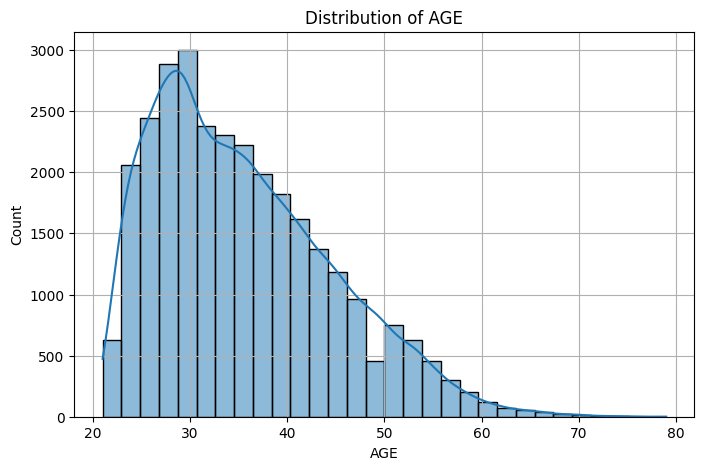

In [37]:
graph_histogram_EDA(X, "AGE")

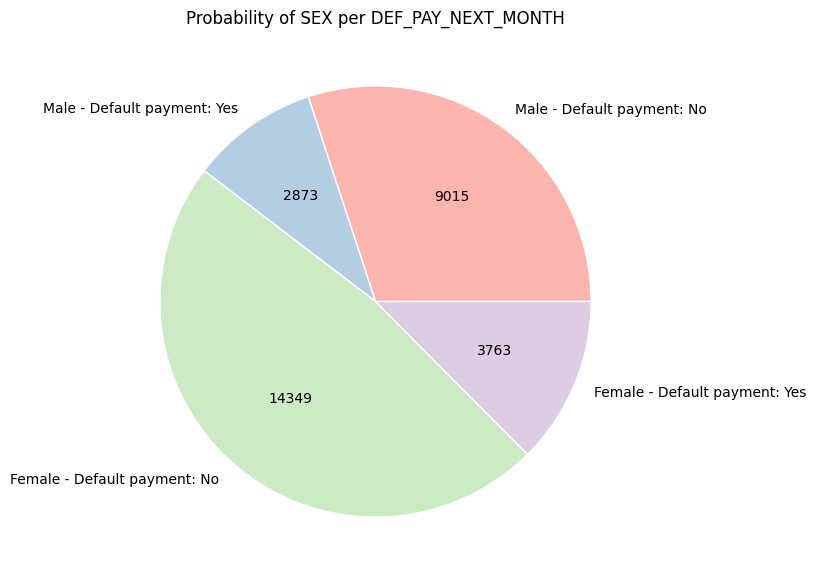

In [38]:
pie_chart_two_fields(X, "SEX", "DEF_PAY_NEXT_MONTH", sex_map, payment_map)

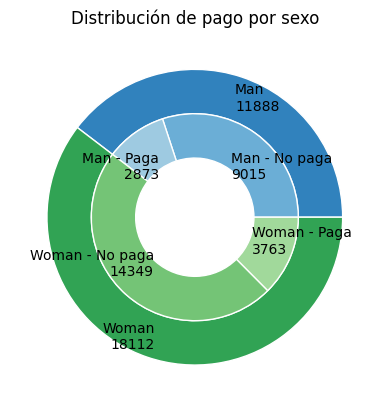

In [32]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
size = 0.3

tab20c = plt.get_cmap("tab20c").colors
outer_colors = [tab20c[i] for i in [0, 8]]
inner_colors = [tab20c[i] for i in [1, 2, 9, 10]]

# Etiquetas para el anillo exterior (sexo)
outer_labels = [f'Man\n{vals[0].sum()}', f'Woman\n{vals[1].sum()}']

# Etiquetas para el anillo interior (pago)
inner_labels = [
    f'Man - No paga\n{vals[0,0]}', f'Man - Paga\n{vals[0,1]}',
    f'Woman - No paga\n{vals[1,0]}', f'Woman - Paga\n{vals[1,1]}'
]

# Anillo exterior (sexo)
ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=outer_labels, labeldistance=0.85)

# Anillo interior (pago)
ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=inner_labels, labeldistance=0.6)

ax.set(aspect="equal", title='Distribución de pago por sexo')
plt.show()


In [51]:
X.groupby(['SEX', 'DEF_PAY_NEXT_MONTH']).size().unstack(fill_value=0)


DEF_PAY_NEXT_MONTH,0,1
SEX,,
1,9015,2873
2,14349,3763


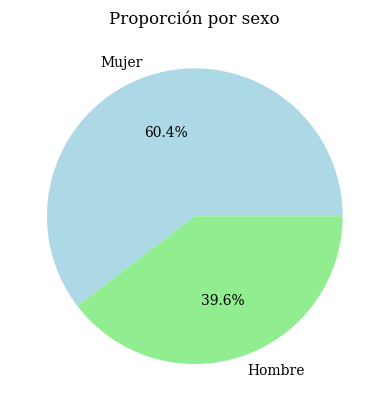

In [28]:
X['SEX'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Mujer', 'Hombre'], colors=['lightblue', 'lightgreen'])
plt.title('Proporción por sexo')
plt.ylabel('')  # Quitar etiqueta
plt.show()

In [ ]:
# Warnings con la data:
# 1. Education de la copia directa, tiene más atributos.


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error


In [61]:
corr_matrix = X_default_df.corrwith(Y_default_df)
print(corr_matrix.sort_values(ascending=False))


PAY_1        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
EDUCATION    0.028006
AGE          0.013890
BILL_AMT6   -0.005372
BILL_AMT5   -0.006760
BILL_AMT4   -0.010156
BILL_AMT3   -0.014076
BILL_AMT2   -0.014193
BILL_AMT1   -0.019644
MARRIAGE    -0.024339
SEX         -0.039961
PAY_AMT6    -0.053183
PAY_AMT5    -0.055124
PAY_AMT3    -0.056250
PAY_AMT4    -0.056827
PAY_AMT2    -0.058579
PAY_AMT1    -0.072929
LIMIT_BAL   -0.153520
dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import pandas as pd

# 1. Separar features y target
X_default_df = X.drop(["DEF_PAY_NEXT_MONTH"], axis=1)
Y_default_df = X["DEF_PAY_NEXT_MONTH"]

# 2. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_default_df, Y_default_df, test_size=0.2, random_state=42
)

# 3. Definir pipeline con RFE y escalado
# Primero seleccionamos 10 features con RFE y luego escalamos antes del modelo
model = LogisticRegression(max_iter=5000, solver='saga', random_state=42)

pipeline = Pipeline([
    ('feature_selection', RFE(model, n_features_to_select=10)),
    ('scaler', StandardScaler()),
    ('classifier', model)
])

# 4. Entrenar pipeline con el set de entrenamiento
pipeline.fit(X_train, y_train)

# 5. Evaluar con test
y_pred = pipeline.predict(X_test)

# 6. (Opcional) Obtener las features seleccionadas
selected_features_mask = pipeline.named_steps['feature_selection'].support_
selected_features = X_train.columns[selected_features_mask]
print("Features seleccionadas:", list(selected_features))

# 7. Evaluar desempeño
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Prediction of the variable ***default.payment.next.month*** (binary variable)

In [37]:
# Prepare data

## Separation of feature columns and solution columns of the data frame
X_default_df = X.drop(["DEF_PAY_NEXT_MONTH"], axis=1)
Y_default_df = X["DEF_PAY_NEXT_MONTH"]

## Getting of training and test sets
X_default_TRAIN_df, X_default_TEST_df, \
Y_default_TRAIN_df, Y_default_TEST_df = train_test_split(X_default_df, Y_default_df, test_size=0.2, random_state=42)

## StandardScaler for train set
scaler = StandardScaler()
X_default_TRAIN_scaled = scaler.fit_transform(X_default_TRAIN_df)
X_default_TEST_scaled  = scaler.transform(X_default_TEST_df)

# 4. Convertir los escalados en DataFrames (opcional, para legibilidad)
X_default_TRAIN_scaled_df = pd.DataFrame(X_default_TRAIN_scaled, columns=X_default_TRAIN_df.columns, index=X_default_TRAIN_df.index)
X_default_TEST_scaled_df  = pd.DataFrame(X_default_TEST_scaled,  columns=X_default_TEST_df.columns,  index=X_default_TEST_df.index)

## Logistic Regression

In [46]:
# 6. Entrenar la regresión logística
model = LogisticRegression(max_iter=1000)
model.fit(X_default_TRAIN_scaled_df, Y_default_TRAIN_df)

LogisticRegression(max_iter=1000)

In [47]:
# 7. Predicción (opcional)
y_pred = model.predict(X_default_TEST_scaled_df)

In [48]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
print(classification_report(y_pred, Y_default_TEST_df))
print(confusion_matrix(y_pred, Y_default_TEST_df))
print('\nAccuracy Score for model1: ', accuracy_score(y_pred,Y_default_TEST_df))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      5551
           1       0.24      0.69      0.35       449

    accuracy                           0.81      6000
   macro avg       0.60      0.76      0.62      6000
weighted avg       0.92      0.81      0.85      6000

[[4549 1002]
 [ 138  311]]

Accuracy Score for model1:  0.81


In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from imblearn.over_sampling import SMOTE
import pandas as pd

# --- 1. Separar features y target
X_default_df = X.drop(["DEF_PAY_NEXT_MONTH"], axis=1)
Y_default_df = X["DEF_PAY_NEXT_MONTH"]

# --- 2. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_default_df, Y_default_df, test_size=0.2, random_state=42
)

# --- 3. Aplicar SMOTE SOLO en entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Distribución antes SMOTE:\n{y_train.value_counts()}")
print(f"Distribución después SMOTE:\n{y_train_res.value_counts()}")

# --- 4. Escalar datos con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled  = scaler.transform(X_test)

# --- 5. Entrenar regresión logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train_res)

# --- 6. Obtener probabilidades para test
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# --- 7. Buscar umbral óptimo para maximizar F1-score
thresholds = [i/100 for i in range(10, 100)]
best_threshold = 0.5
best_f1 = 0

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Mejor umbral: {best_threshold:.2f} con F1-score: {best_f1:.3f}")

# --- 8. Predecir con el mejor umbral
y_pred_final = (y_probs >= best_threshold).astype(int)

# --- 9. Evaluar resultados finales
print("\nReporte de clasificación con mejor umbral:")
print(classification_report(y_test, y_pred_final))


Distribución antes SMOTE:
DEF_PAY_NEXT_MONTH
0    18677
1     5323
Name: count, dtype: int64
Distribución después SMOTE:
DEF_PAY_NEXT_MONTH
0    18677
1    18677
Name: count, dtype: int64
Mejor umbral: 0.52 con F1-score: 0.455

Reporte de clasificación con mejor umbral:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      4687
           1       0.38      0.56      0.46      1313

    accuracy                           0.71      6000
   macro avg       0.62      0.65      0.63      6000
weighted avg       0.75      0.71      0.72      6000



## Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()

In [31]:
# Escalamos y convertimos de nuevo a DataFrame
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_default_df),
    columns=X_default_df.columns,
    index=X_default_df.index
)

In [32]:
X_scaled_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,0.810161,0.185828,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,...,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,0.810161,0.185828,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,...,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.810161,0.185828,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,...,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,-1.234323,0.185828,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,...,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,-1.234323,1.451114,-1.057295,0.381275,0.014861,0.111736,0.138865,0.188746,0.234917,...,2.326690,0.695474,-0.149259,-0.384392,0.171250,0.611048,-0.012648,-0.113564,0.013131,-0.237130
29996,-0.134759,-1.234323,1.451114,0.858557,0.815221,-0.874991,-0.723570,-0.696663,-0.666599,0.234917,...,-0.627430,-0.532924,-0.577691,-0.652724,-0.231032,-0.103955,0.214255,-0.299828,-0.314136,-0.293382
29997,-1.059646,-1.234323,0.185828,0.858557,0.164303,3.574267,2.617654,1.809921,-0.666599,0.234917,...,-0.638158,-0.347961,-0.324517,-0.327687,-0.341942,-0.256990,0.952725,-0.039964,-0.183229,-0.119001
29998,-0.674276,-1.234323,1.451114,-1.057295,0.598248,0.904712,-0.723570,0.138865,0.188746,0.234917,...,0.422373,0.147844,-0.468063,0.169130,4.844316,-0.109033,-0.229895,-0.185120,3.152536,-0.191904


In [25]:
# Initialize and train Logistic Regression model
model = LogisticRegression(solver='saga', max_iter=1000)
model.fit(X_default_TRAIN_df, Y_default_TRAIN_df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, solver='saga')

In [60]:
# Generate predictions
y_pred = model.predict(X_def_test_df)
accuracy = accuracy_score(Y_def_test_df, y_pred)
print("Accuracy Score: ", accuracy)

Accuracy Score:  0.80775


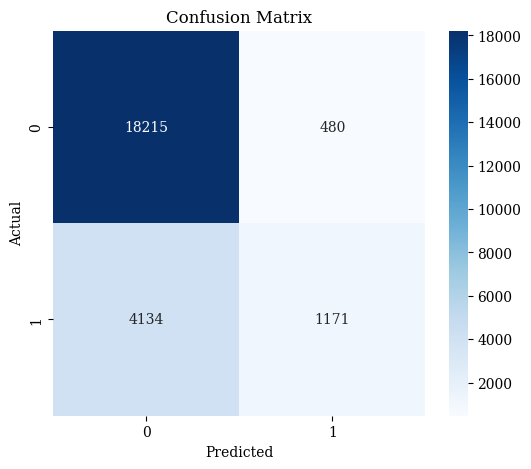

In [61]:
# Confusion Matrix
cm = confusion_matrix(Y_def_test_df, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# ROC Curve computation
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

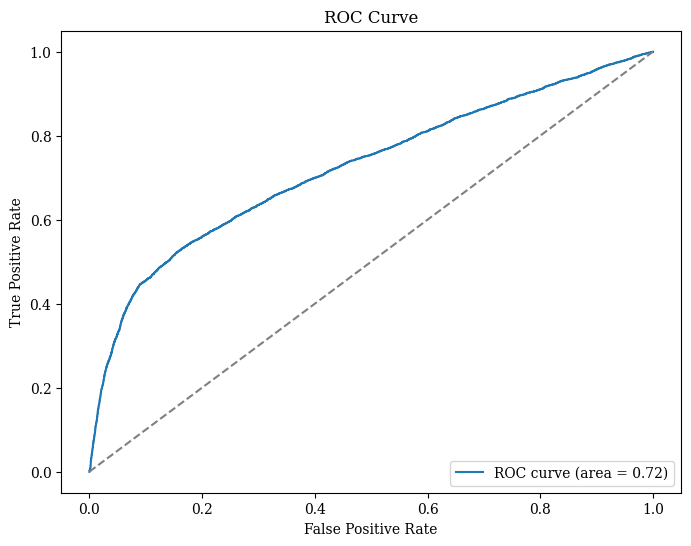

In [64]:
# ROC Curve computation
y_prob = model.predict_proba(X_def_test_df)[:,1]
fpr, tpr, thresholds = roc_curve(Y_def_test_df, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

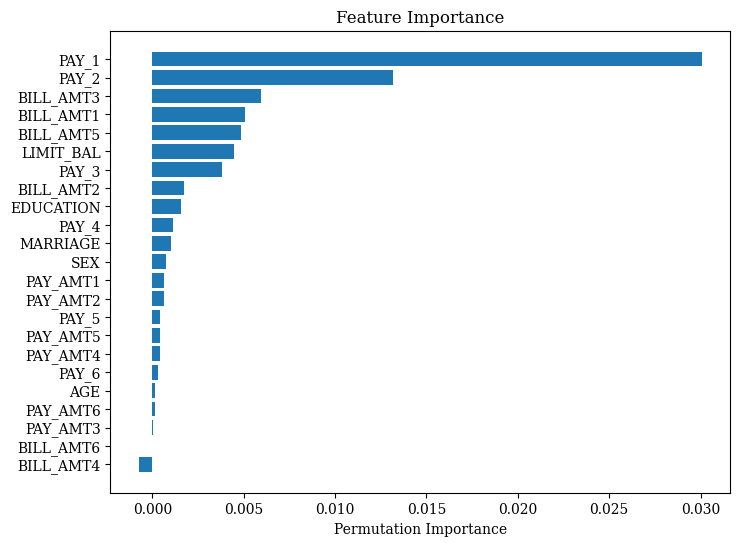

In [65]:
# Permutation Importance to assess feature contributions
result = permutation_importance(model, X_def_test_df, Y_def_test_df, n_repeats=10, random_state=42, scoring='accuracy')
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8,6))
plt.barh(np.array(X.columns)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

In [66]:
from sklearn.linear_model import LinearRegression


In [67]:
# Linear Regression
log1 = LinearRegression()
model1 = log1.fit(X_def_train_df,Y_def_train_df)
model1.score(X_def_test_df, Y_def_test_df)

0.12278102273906466

In [72]:
Y_pred = model1.predict(X_def_test_df)

In [75]:
import pandas as pd

test = pd.DataFrame({
    'Real': Y_def_test_df.values.flatten(),
    'Predicho': Y_pred.flatten()
})


In [76]:
test[test["Real"]==1]

,Real,Predicho
4,1,0.207758
6,1,0.358052
13,1,0.677621
19,1,0.528921
21,1,0.246003
...,...,...
23983,1,0.301616
23987,1,0.251525
23990,1,0.195038
23991,1,0.222975


In [77]:
import statsmodels.api as sm

X_const = sm.add_constant(X_def_test_df)  # añade el intercepto
modelo_sm = sm.OLS(y, X_const).fit()
print(modelo_sm.summary())

ValueError: The indices for endog and exog are not aligned